______
<img style="float: right;" src="./images/headerlogo.png">
## Google Earth Engine Tutorial
### Histograms
_____

In previous examples, multiband images were displayed in RGB combination providing the *min* and *max*  parameters to strecth digital levels to 0 - 256 values.  A Styled Layer Descriptor (SLD) can also be used in GEE for image display. <br> 
With the RasterSymbolizer element we can specify the pixel strecth we want to apply. <br>
There is only three possibilities:
<ul>
<li>Normalize: stretch the image contrast by mapping the minimum and maximum image values to the minimun and maximum brightness.
<li>Histogram: stretch the image contrast by distributing an equal number of pixels at each brghtness value
<li>GammaValue: adjust the brightness of the image. A value of 1 means no change 
</ul><br>
More complicated visualizations can be created. For additional info, check the link: http://docs.geoserver.org/latest/en/user/styling/sld/reference/rastersymbolizer.html

In [1]:
import ee
from IPython.display import Image
ee.Initialize()

image = ee.Image("users/rosamaguilar/tutorial/subset")

# Define a RasterSymbolizer element with '_enhance_' for a placeholder.
template_sld = '<RasterSymbolizer>' + \
    '<ContrastEnhancement><_enhance_/></ContrastEnhancement>' + '<ChannelSelection>' +\
      '<RedChannel>' + '<SourceChannelName>b5</SourceChannelName>' + '</RedChannel>' + \
    '<GreenChannel>' + '<SourceChannelName>b3</SourceChannelName>' + '</GreenChannel>' + \
    '<BlueChannel>' + '<SourceChannelName>b2</SourceChannelName>' + '</BlueChannel>' +\
    '</ChannelSelection>' + '</RasterSymbolizer>'

# Get SLDs with different enhancements.
equalize_sld = template_sld.replace('_enhance_', 'Histogram');  # Equalized
normalize_sld = template_sld.replace('_enhance_', 'Normalize');

# Display the image with a histogram equalization stretch.
# band names of the outputs images are related to the type of sld used
Image(url = image.sldStyle(equalize_sld).getThumbUrl({}))

In [2]:
# Display the image using  Normalize stretch
image = image.sldStyle(normalize_sld)
Image(url = image.getThumbUrl({}))

Above examples shows a predefined style, but it could be of interest to modify the histogram applying a customized stretch. First we should explore the original histogram. To do this, we will apply a *reducer* called *frequencyHistogram* over a region that for this case will be the whole image. 

A **reducer** makes common calculation such as minimum, maximum, median, first, count, etc. It can be applied to a neighbourhood, region, etc. 

The function *reduceRegion* will be applied over the whole image to obtain the values for the histogram. 

The following parameters can be specified for the function <i>reduceRegion</i>:

+ *reducer*: the *reducer* to apply.
+ *geometry*: region over which the reducer will be applied. By default is the footprint (extent) of the image's first band. <br> 
+ *scale*: scale in meters of the projection. 
+ *crs*: the projection to work in.
+ *crsTransform*: a list of values to apply a transformation of the CRS. Default value: null.
+ *bestEffort*: a flag to indicate that the calculation can be done at larger scale to succeed if too many pixels are involved. Default value: False.
+ *maxPixels*: the maximum number of pixels to process. Default value:10000000.
+ *tileScale*: A scaling factor to aggregate tile size. Default value:1. Using higher values would reduce the memory needed to finish the computation. 

In [3]:
# visualize the image without any stretch
# load the image
image = ee.Image("users/rosamaguilar/tutorial/subset"); 
# Visualize the image
Image(url=image.getThumbUrl({'min': 0, 'max': 2048,'bands': 'b5,b3,b2'}))

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# compute the histogram 
# set the geometry of the image to use as region in the function reduceRegion
geom = image.geometry()
# set the original scale of the image
scale = image.projection().nominalScale()
# compute the histogram
bfreq = image.reduceRegion(
  reducer = ee.Reducer.frequencyHistogram(),    #.unweighted(),
  geometry = geom,
  scale = scale,
  maxPixels = 10000000 ).getInfo()
#print(bfreq)

# The output of reduceRegion is a dictionary with the format:
# {'bandname': {'key':value}}
    
# We will build series  for x values and y values in order to build the histogram    

# define two dictionaries for frequencies and values respectively
freqs= dict()
vals = dict()

# populate dictionaries
for l in bfreq.keys():
    
    d = bfreq[l]
    #print(d)
    freq = []
    val = []
    for k,v in d.items():
        #print(k,v)
        if not(k == 'null'):
            val.append(int(k))
            freq.append(int(v))
    freqs[l] = freq 
    vals[l] = val
    print('Minimum and maximum value for : %s is %.2f %.2f' % (l, np.min(val), np.max(val) ))
    #print(freqs[l]),np.min(val)

Minimum and maximum value for : b5 is 0.00 9114.00
Minimum and maximum value for : b2 is 0.00 10486.00
Minimum and maximum value for : b4 is 0.00 8015.00
Minimum and maximum value for : b8 is 0.00 10267.00
Minimum and maximum value for : b3 is 0.00 8531.00
Minimum and maximum value for : b1 is 0.00 7679.00
Minimum and maximum value for : b7 is 317.00 8766.00
Minimum and maximum value for : b6 is 10.00 9437.00


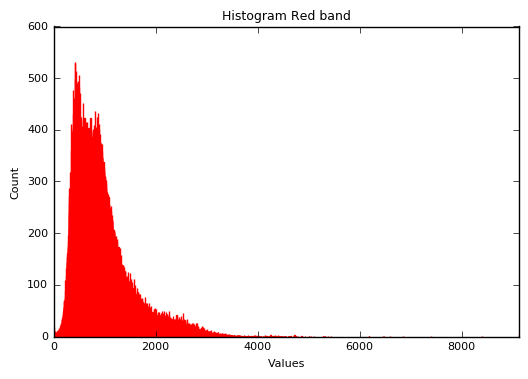

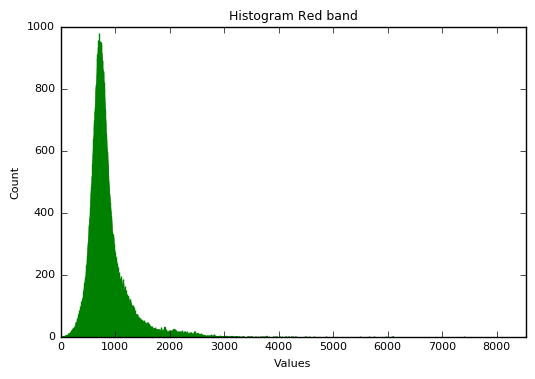

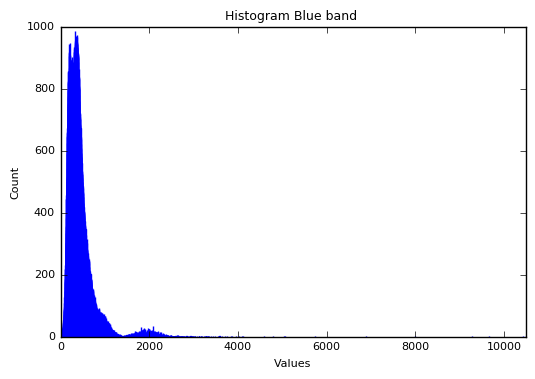

In [5]:
# With the series  freqs and vals, a function will plot histograms for bands b5, b3 and b2
# # function to plot bands red 

def plot_hist(vals, freqs, min = 0, max = 6500, title='Histogram', color = 'red'):
    
    # ind = np.arange(len(vals))  # 
    #plt.bar(vals,freq, color='#d62728',edgecolor='#d62728')  
    #plt.ylabel('Count')
    #plt.title('Histogram Band 5')
    f, ax1 = plt.subplots(1,1)
    #ax1.bar( vals['b5'],freqs['b5'],color='red',edgecolor='red') #d62728
    ax1.bar( vals ,freqs,color=color,edgecolor=color) #d62728
    ax1.set_title(title, fontsize=9)
    ax1.set_xlabel('Values', fontsize=8)
    ax1.set_ylabel('Count', fontsize=8)
    ax1.tick_params( labelsize =8)
    ax1.set_xlim(min,max)
    plt.show()
    
# Call the function    
plot_hist( vals['b5'],freqs['b5'], 0, 9114,"Histogram Red band")
plot_hist(vals['b3'],freqs['b3'], 0,8531, "Histogram Red band", color =  "green")
plot_hist( vals['b2'], freqs['b2'], 0, 10486,"Histogram Blue band ",  "blue")


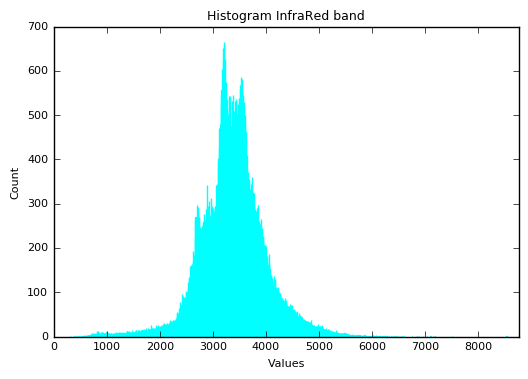

In [6]:
# a plot of infrared band
plot_hist( vals['b7'], freqs['b7'], 0, 8766, "Histogram InfraRed band","cyan")

It is common to apply a linear stretch, deleting  certain percent of pixels considered noise or outlier. The following example deletes 5% of the values by applying *percentile* reducers to get the percentile 2,5 and 97,5% respectively. These values are  set as *minimum* and *maximum* to scale image values to 0 and 255 

In [8]:
# first define a function to transform the image values 
#=================================
# function to transform the image to 255 bits (uint8):
def transformTouint8Reducers(image, perc):
    NameBands = image.bandNames()
    minValues = image.reduceRegion(
          reducer=ee.Reducer.percentile([perc]),
          bestEffort=True,
          maxPixels=100000000,
          ).toImage(NameBands)

    maxValues = image.reduceRegion(
          reducer=ee.Reducer.percentile([100-perc]),
          bestEffort=True,
          maxPixels=100000000,
          ).toImage(NameBands)

    return image.subtract(minValues).divide(maxValues.subtract(minValues)).multiply(255).byte()    # this scale values to 0-255

# Compute the image with pixel values between 0-255
img256 = transformTouint8Reducers(image,2.5)
print("done!")

done!


In [ ]:
# Compute new histograms
geom = img256.geometry()
scale = img256.projection().nominalScale()
# compute the histogram
bfreq = img256.reduceRegion(reducer = ee.Reducer.frequencyHistogram(),geometry = geom, scale = scale,
                             maxPixels = 10000000 ).getInfo()

nfreqs= dict()
nvals = dict()

for l in bfreq.keys():
    d = bfreq[l]
    freq = []
    val = []
    for k,v in d.items():
        if not(k == 'null'):
            val.append(int(k))
            freq.append(int(v))
    nfreqs[l] = freq 
    nvals[l] = val
    #print('Minimum and maximum value for : %s is %.2f %.2f' % (l, np.min(val), np.max(val) ))
  
# Call the function    
plot_hist(nvals['b5'], nfreqs['b5'], 0, 255,"New histogram Red band")
plot_hist(nvals['b3'], nfreqs['b3'], 0, 255, "New Histogram Red band", color =  "green")
plot_hist(nvals['b2'], nfreqs['b2'], 0, 255,"New Histogram Blue band ",  "blue")


In [ ]:
#Show the image before and after the histogram stretch
from IPython.display import display
# image before
img1  = Image(url = image.getThumbUrl({'min': 0, 'max': 2048,'bands': 'b5,b3,b2'}))
# image after
img2  = Image(url = img256.getThumbUrl({'min': 0, 'max': 256,'bands': 'b5,b3,b2'}))

display(img1, img2)
# you may notice that changes are saved into the image img256

Yoy may try to code a function to apply a *Gaussian* enhancement to the image subset.
The Gaussian stretch is centered at the value of 127 (digital level) with the data values in ± 3 standard deviations set to 0 and 255. 